In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

## Identify Recessions Periods

In [2]:
start = '1995-01-01'

In [3]:
today = datetime.today().strftime("%Y-%m-%d")
today

'2020-05-02'

In [4]:
# always the data from start to today
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SP500&scale=left&cosd='+start+'&coed='+today+'&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%20Close&fam=avg&fgst=lin&fgsnd='+start+'&line_index=1&transformation=lin&vintage_date='+today+'&revision_date='+today+'&nd='+start
SP500 = pd.read_csv(url)
SP500['DATE'] = pd.to_datetime(SP500['DATE'])
SP500 = SP500[SP500['SP500'] != '.']
SP500['SP500'] = SP500['SP500'].apply(float)

temp = pd.read_csv("S&P500.csv")
temp['Date'] = pd.to_datetime(temp['Date'])
temp.sort_values("Date",inplace=True)
temp = temp[['Date', 'Adj Close']]
temp = temp[temp['Date'] < SP500.loc[0, 'DATE']].reset_index()
del temp['index']
SP500.columns = temp.columns

df = pd.concat([temp, SP500])
df = df[df['Date'] >= pd.to_datetime(start)].reset_index()
del df['index']
df.sort_values("Date",inplace=True)
df.tail()

,Date,Adj Close
6373,2020-04-27,2878.48
6374,2020-04-28,2863.39
6375,2020-04-29,2939.51
6376,2020-04-30,2912.43
6377,2020-05-01,2830.71


C:\Users\Administrator\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


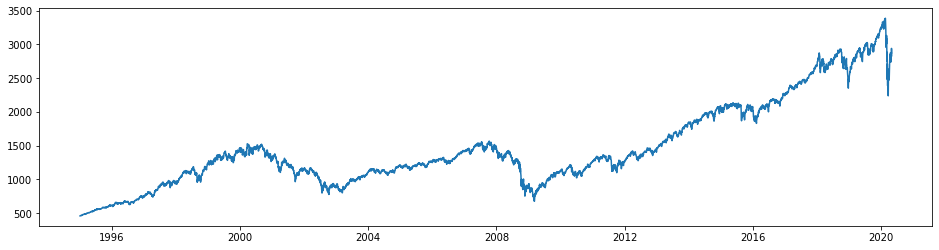

In [5]:
# plot the S&P in the past years
plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Adj Close'])

In [6]:
drawdown_rate = 0.15
def drawdown(df, drawdown_rate, min_days = 90):
    # this function is used to identify a drawdown
    
    # recession_rate: the percentage used to identify a drawdown
    # min_days: the minimum length of a recession
    
    recessions = list()
    days = df.shape[0]
    for i in range(0,days):
        for j in range(i+1,days):
            if df.loc[j,'Adj Close'] <= df.loc[i,'Adj Close']*(1-drawdown_rate):
                temp = df.loc[i:j,:]
                max_index = temp[temp['Adj Close'] == temp['Adj Close'].max()].index[-1]
                if ((df.loc[max_index,'Date'],df.loc[j,'Date']) not in recessions):
                    recessions.append((df.loc[max_index,'Date'],df.loc[j,'Date']))
                    if max_index>j:
                        raise ValueError
                break
    recessions = sorted(recessions, key = lambda x: x[0])
    
    rec = list()
    for i in range(len(recessions)-1):
        if len(rec)==0:
            if recessions[i][1] >= recessions[i+1][0]:
                if recessions[i][1]<=recessions[i+1][1]:
                    rec.append((recessions[i][0],recessions[i+1][1]))
                elif recessions[i][1]>=recessions[i+1][1]:
                    rec.append((recessions[i][0],recessions[i][1]))
        else:
            if recessions[i][0] <= rec[-1][1]:
                if rec[-1][1]<=recessions[i+1][1]:
                    rec[-1]=(rec[-1][0], recessions[i][1])
            else:
                rec.append(recessions[i])
                
    rec_periods = list()
    timediff = pd.Timedelta(days=min_days)
    for i in range(len(rec)):
        if i == 0:
            rec_periods.append(rec[0])
        elif rec[i][0] - rec_periods[-1][1] <= timediff:
            rec_periods[-1] = (rec_periods[-1][0],rec[i][1])
        else:
            rec_periods.append(rec[i])
    return rec_periods

drawdowns = drawdown(df, drawdown_rate)
drawdowns

[(Timestamp('1998-07-17 00:00:00'), Timestamp('1998-08-31 00:00:00')),
 (Timestamp('2000-03-24 00:00:00'), Timestamp('2002-10-09 00:00:00')),
 (Timestamp('2007-10-09 00:00:00'), Timestamp('2009-03-02 00:00:00')),
 (Timestamp('2010-04-23 00:00:00'), Timestamp('2010-07-02 00:00:00')),
 (Timestamp('2011-04-29 00:00:00'), Timestamp('2011-10-03 00:00:00')),
 (Timestamp('2018-09-20 00:00:00'), Timestamp('2018-12-24 00:00:00')),
 (Timestamp('2020-02-19 00:00:00'), Timestamp('2020-03-20 00:00:00'))]

Text(0, 0.5, 'S&P 500 Index')

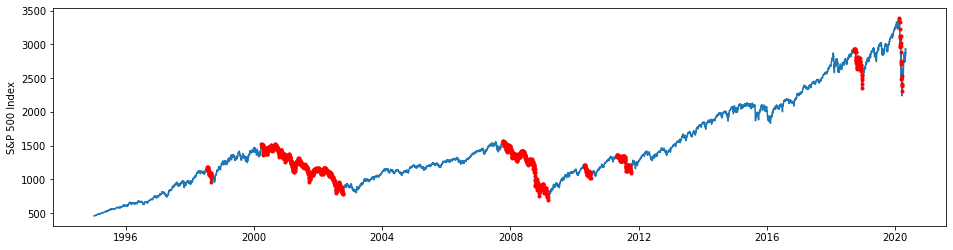

In [7]:
# print out the drawd

rec_index = list()
for (x, y) in drawdowns:
    rec_index.extend([z for z in range(df[df['Date'] == x].index[0],df[df['Date'] == y].index[0]+1)])
plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Adj Close'], marker='o', markerfacecolor='r',markeredgecolor='r', markersize=3 ,markevery=rec_index)
plt.ylabel('S&P 500 Index')

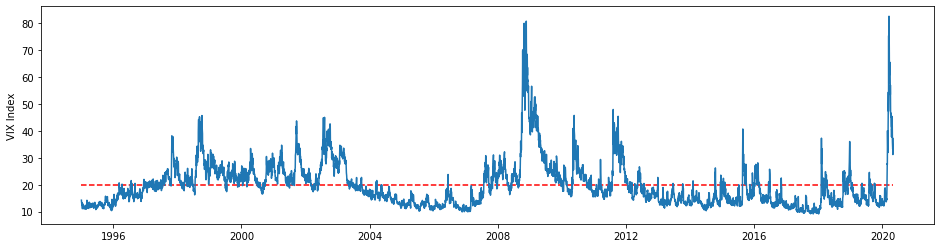

In [8]:
VIX_before2004 = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',header = 1)
VIX_after2004 = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', header = 1)
VIX = pd.concat([VIX_before2004, VIX_after2004]).reset_index()
del VIX['index']
VIX = VIX[['Date', 'VIX Close']]
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX = VIX[VIX['Date'] >= df.loc[0, 'Date']]

plt.figure(figsize=(16,4))
plt.plot(VIX['Date'],VIX['VIX Close'])
plt.ylabel('VIX Index')

plt.hlines(20, min(VIX['Date']), max(VIX['Date']), colors = "r", linestyles = "dashed")

#### There are too many noises in the graph above, so we use the simple moving avrage of VIX index to make a smoother curve

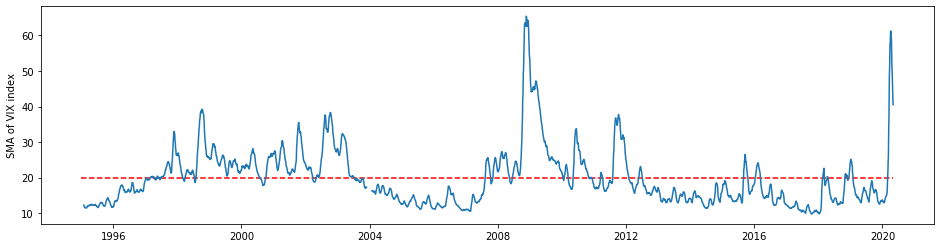

In [9]:
# calculate the moving avrage of VIX index to demilish noises
VIX['VIX_SMA'] = VIX.loc[:,'VIX Close'].rolling(window=21).mean()

plt.figure(figsize=(16,4))
plt.plot(VIX['Date'],VIX['VIX_SMA'])
plt.ylabel('SMA of VIX index')

plt.hlines(20, min(VIX['Date']), max(VIX['Date']), colors = "r", linestyles = "dashed")

In [10]:
def VIX_recovery(start, end, VIX):
    # This function is used to idetnify recessions with drawdown and recovery period
    
    # start: the start date of a drawdown
    # end: the end date of a drawdown
    # VIX: VIX index data
    
    vix0 = VIX[VIX['Date'] == start].index[0]
    for i in range(vix0, VIX.shape[0]):
        if VIX.loc[i, 'VIX_SMA'] <= 20 and VIX.loc[i, 'Date'] > end:
            return((start, VIX.loc[i, 'Date']))
    return((start, end))

reccessions = list()
for i in range(len(drawdowns)):
    reccessions.append(VIX_recovery(drawdowns[i][0], drawdowns[i][1], VIX))
# reccessions = [x for x in reccessions if x != None]


# print out the identified recession periods
reccessions

[(Timestamp('1998-07-17 00:00:00'), Timestamp('2000-07-26 00:00:00')),
 (Timestamp('2000-03-24 00:00:00'), Timestamp('2003-07-09 00:00:00')),
 (Timestamp('2007-10-09 00:00:00'), Timestamp('2010-01-13 00:00:00')),
 (Timestamp('2010-04-23 00:00:00'), Timestamp('2010-11-05 00:00:00')),
 (Timestamp('2011-04-29 00:00:00'), Timestamp('2012-02-02 00:00:00')),
 (Timestamp('2018-09-20 00:00:00'), Timestamp('2018-12-24 00:00:00')),
 (Timestamp('2020-02-19 00:00:00'), Timestamp('2020-03-20 00:00:00'))]

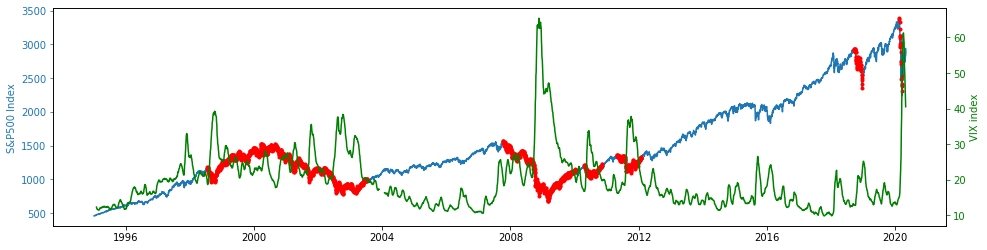

In [11]:
rec_index = list()
for (x, y) in reccessions:
    rec_index.extend([z for z in range(df[df['Date'] == x].index[0],df[df['Date'] == y].index[0]+1)])
    
# plt.figure(figsize=(16,4))
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(111)
p1, = ax1.plot(df['Date'],df['Adj Close'], marker='o', markerfacecolor='r',markeredgecolor='r', markersize=3 ,markevery=rec_index)
ax1.set_ylabel('S&P500 Index')

ax2 = ax1.twinx()
p2, = ax2.plot(VIX['Date'],VIX['VIX_SMA'],'g')
ax2.set_ylabel('VIX index')

ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())

plt.show()

# plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime(today))

In [12]:
reccessions

[(Timestamp('1998-07-17 00:00:00'), Timestamp('2000-07-26 00:00:00')),
 (Timestamp('2000-03-24 00:00:00'), Timestamp('2003-07-09 00:00:00')),
 (Timestamp('2007-10-09 00:00:00'), Timestamp('2010-01-13 00:00:00')),
 (Timestamp('2010-04-23 00:00:00'), Timestamp('2010-11-05 00:00:00')),
 (Timestamp('2011-04-29 00:00:00'), Timestamp('2012-02-02 00:00:00')),
 (Timestamp('2018-09-20 00:00:00'), Timestamp('2018-12-24 00:00:00')),
 (Timestamp('2020-02-19 00:00:00'), Timestamp('2020-03-20 00:00:00'))]

## Rolling Validation

### 1. Input Simple Trading Signals

In [13]:
industry = r'Consumer_Discretionary'
df = pd.read_csv(industry+r'_all_companies.csv')
#delete wrong columns
for column in ['Unnamed: 0','return5','return10','signal3','signal5','signal10']:
    del df[column]
df['Dates'] =  pd.to_datetime(df['Dates'],format='%Y-%m-%d')
df.sort_values("Dates",inplace=True)
df = df.reset_index()
del df['index']
df.head()

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,KAMA_crossover,SAR_crossover,TEMA_crossover,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3
0,2000-01-18,26400.0,1.1458,1.1458,1.2292,1.2292,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.051726
1,2000-01-18,402750.0,11.1182,10.9690,11.3421,11.1928,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2000-01-18,800800.0,4.7578,4.7344,4.8594,4.8594,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.025600
3,2000-01-18,434900.0,7.3750,7.2813,7.5625,7.3750,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.035088
4,2000-01-18,13000.0,16.1875,16.1875,16.2500,16.1875,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.003876


### 2. Identify the dependent variable: 3-day return

In [14]:
df['intraday_return'] = df['return3']
del df['return3']
df.head()

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,KAMA_crossover,SAR_crossover,TEMA_crossover,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,intraday_return
0,2000-01-18,26400.0,1.1458,1.1458,1.2292,1.2292,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.051726
1,2000-01-18,402750.0,11.1182,10.9690,11.3421,11.1928,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000
2,2000-01-18,800800.0,4.7578,4.7344,4.8594,4.8594,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.025600
3,2000-01-18,434900.0,7.3750,7.2813,7.5625,7.3750,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.035088
4,2000-01-18,13000.0,16.1875,16.1875,16.2500,16.1875,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.003876


### 3. Select the most important 20 complex rules

In [15]:
def feature_selection(X, Y, m = 3, n_estimators=10):
    '''
    This function is used to select the 30 most important simgle or complex trading signals
    '''
    
    # X is the independant variables of train data
    # Y is the dependant variables of train data
    # m-day return
    # n_estimators is the parameter of RF model
       
    x_train = X.copy()
    y_train = Y.copy()
    
    ####################################################  select top10 simple rules
    model = RandomForestClassifier(n_estimators)
    model.fit(x_train,y_train['signal'+str(m)])
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feat_labels = x_train.columns
    top10 = [feat_labels[indices[i]] for i in range(x_train.shape[1])][-10:]

    #################################################### construct 2-way rules
    for i in range(9):
        for j in range(10):
            x_train[top10[i] + '+' + top10[j]] = \
                np.array([1 if x+y>0 else -1 if x+y<0 else 0 for (x, y) in zip(x_train[top10[i]], x_train[top10[j]])]) 
            
    #################################################### construct 3-way rules
    three_way_columns = []
    for i in range(8):
        for j in range(i+1, 9):
            for k in range(j+1, 10):
                x_train[top10[i] + '+' + top10[j] + '+' + top10[k]] = \
                np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(x_train[top10[i]], x_train[top10[j]], x_train[top10[k]])]) 

    #################################################### select top20 rules       
    model2 = RandomForestClassifier(n_estimators)
    model2.fit(x_train, y_train['signal'+str(m)])
    importances2 = model2.feature_importances_
    indices2 = np.argsort(importances2)
    feat_labels = x_train.columns
    top20 = [feat_labels[indices2[i]] for i in range(x_train.shape[1])][-20:]
    
    return x_train[top20]


### 4. Define a function to combine simple trading signas and 

In [16]:
def feature_combination(df, feature_list):
    # feature_list: the selected single and complex trading rules that needs to be generated in the test set
    
    temp = df.copy()
    for x in feature_list:
        features = x.split('+')
        if len(features) == 2:
            temp[x] = np.array([1 if x+y>0 else -1 if x+y<0 else 0 for (x, y) in zip(temp[features[0]], temp[features[1]])])
        if len(features) == 3:
            temp[x] = np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(temp[features[0]], temp[features[1]], temp[features[2]])])
    temp = temp[feature_list]
    return temp

### 5. The forward rolling model

In [26]:
def Rolling_model(data, valid = True, test = False, test_para = 10, n_splits = 5, th = 0.0067, m = 3, n = 200, k = 21, parameters=None):

    # n_splits is the number of folds when spliting train set and test set
    # th is the thershold return rate used to generate trading signals
    # n days rolling windows and refit the model every K days because the portfolio is rebalanced
    # m-days return

    df = data.copy()
    df.sort_values("Dates",inplace=True)

    X = df['Dates'].unique()
    N = len(X) 
    df['return'+str(m)] = df['intraday_return'].shift(-m)
    df = df.dropna()
    df['signal'+str(m)] = np.where(df['return'+str(m)] > th, 1 ,np.where(df['return'+str(m)] < -th, -1, 0))            

    if valid == True:
        N_valid = 0
        validation_performance = np.zeros(len(parameters))
        
        step = 0

        for i in range(0,N-(n+k),k):
            print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
            step = step + 1
            train_data = X[i:i+n]
            tscv = TimeSeriesSplit(max_train_size=None, n_splits = n_splits)

            for train_index,valid_index in tscv.split(train_data):
                train_dates = pd.to_datetime(train_data[train_index])
                f = lambda x: True if x in train_dates else False
                train = df[df['Dates'].apply(f)]
                x_train = train.iloc[:,6:-3]
                y_train = train.iloc[:,-2:]

                #The first m days in validation set should be blocked
                #At each fold, we only use the t = m+1 day as validation data.
                valid_dates = pd.to_datetime(train_data[valid_index][m])
                valid = df[df['Dates'] == valid_dates]
                x_valid = valid.iloc[:,6:-3]
                y_valid = valid.iloc[:,-2:]
                N_valid += len(y_valid)

                #set the random forest
                for j in range(len(parameters)):
                    x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = parameters[j])
                    x_valid = feature_selection(X = x_valid, Y = y_valid, m = m, n_estimators = parameters[j])
                    model = RandomForestClassifier(n_estimators=parameters[j])
                    model.fit(x_train,y_train['signal'+str(m)])
                    y_pred_val = model.predict(x_valid)
                    validation_performance[j] += np.sum(y_pred_val == y_valid['signal'+str(m)])

        print('N_valid: ',N_valid, ', validation_performance: ', validation_performance)
        return N_valid, validation_performance

    if test == True and test_para != None:
        test_performance = 0
        #real value for test set
        y_real = np.array([],dtype='int')
        y_pred = np.array([],dtype='int')

        step = 0
        
#         count = 0
        for i in range(0,N-(n+k),k):
            try:
                print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
                step = step + 1

                y_real = np.concatenate((y_real,np.array(df[df['Dates'] == X[i+n+m]]['signal'+str(m)])))

                train_dates = pd.to_datetime(X[i:i+n])
                f = lambda x: True if x in train_dates else False
                train = df[df['Dates'].apply(f)]
                x_train = train.iloc[:,6:-3]
                y_train = train.iloc[:,-2:]

                x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = test_para)

                model = RandomForestClassifier(n_estimators = test_para)
                model.fit(x_train,y_train['signal'+str(m)])

                test_data = df[df['Dates'] == X[i+n+m]]
                x_test = test_data.iloc[:,6:-3]
                y_test = test_data.iloc[:,-2:]

                x_test = feature_combination(x_test, list(x_train.columns))

                prediction = model.predict(x_test)
                y_pred = np.concatenate((y_pred, np.array(prediction)))
            except:
                pass
#             count=count+1
#             if count >=2:
#                 break

        return y_real, y_pred

### 6. Identify the recession period that we are going to train our model

In [19]:
def select_recession(n, df, reccessions):
    start = reccessions[n][0]
    end = reccessions[n][1]
    df1 = df.copy()
    df1 = df1[df1['Dates'] >= start]
    df1 = df1[df1['Dates'] <= end]
    return df1

In [20]:
def set_th(th, df, m):
    # m-day return
    df['signal'+str(m)] = np.where(df['intraday_return'] > th, 1 ,np.where(df['intraday_return'] < -th, -1, 0))
    print('When the threshold is '+str(th)+':')
    print('signal'+str(m)+'\n', df['signal3'].value_counts()/df.shape[0])

In [21]:
df1 = select_recession(2, df, reccessions)
set_th(0.12, df1, m = 3)

When the threshold is 0.12:
signal3
  0    0.902411
 1    0.053551
-1    0.044038
Name: signal3, dtype: float64


### 7. Identify the optimal number of trees in the RF model

In [24]:
def validation_performance(df, parameters, th = 0.035, plot = True, k= 21, n = 200, n_splits = 5):
    N_valid, validation_performance = Rolling_model(df, valid = True, test = False, test_para = 10, th = th, k= k, n = n, n_splits = n_splits, parameters = parameters)
    n_estimator = dict()
    for i in range(len(parameters)):
        n_estimator[parameters[i]] =  validation_performance[i]/N_valid
#         print( validation_performance[i], N_valid, n_estimator[parameters[i]])
    
    if plot == True:
        plt.figure(figsize=(8,4))
        plt.plot(list(n_estimator.keys()),list(n_estimator.values()))
        plt.xlabel("number of decision trees in the random forest") 
        plt.ylabel("Validation Accuracy")
    
    return n_estimator

0 of 17
1 of 17
2 of 17
3 of 17
4 of 17
5 of 17
6 of 17
7 of 17
8 of 17
9 of 17
10 of 17
11 of 17
12 of 17
13 of 17
14 of 17
15 of 17
16 of 17
17 of 17
N_valid:  17751 , validation_performance:  [7134. 7321. 7272. 7299. 7169.]


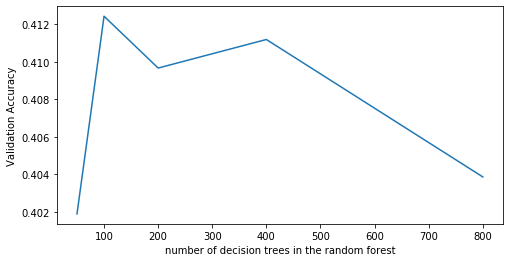

In [27]:
'''
the tunning parameter is n_estimators: 
Generally speaking, n_estimators is too small, which is easy to underfit. If n_estimators is too large, 
the amount of calculation will be too large, and after n_estimators reaches a certain number, 
increasing the model gain obtained by n_estimators will be small, so generally choose a moderate value. The default is 100.
'''
parameters = [50, 100, 200, 400, 800]

vp1 = validation_performance(df1, parameters)

From the graph we can see that when the number of trees exceed 100, the test accuracy increased slowly. So 100 is the optimal value.

In [28]:
vp1

{50: 0.40189285110697986,
 100: 0.41242746887499293,
 200: 0.40966706101064726,
 400: 0.4111881020787561,
 800: 0.40386457101008394}

In [29]:
op_tree = 100
op_tree

100

In [30]:
def test_performance(df, test_para, th, k = 21, n = 200, n_splits = 5):
    y_real, y_pred = Rolling_model(df, valid = False, test = True, test_para = test_para, th = th, k = k, n = n, n_splits = n_splits)
    test_accuracy = np.sum(y_real == y_pred)/len(y_real)
    return(test_accuracy)

test_performance(df1, test_para = op_tree, th = 0.035)

0 of 17
1 of 17
2 of 17
3 of 17
4 of 17
5 of 17
6 of 17
7 of 17
8 of 17
9 of 17
10 of 17
11 of 17
12 of 17
13 of 17
14 of 17
15 of 17
16 of 17
17 of 17


0.4091671324762437

### 8. Identify the optimal window length

In [36]:
wl = [21*x for x in range(3,13)]
parameters = [op_tree]   # only choose the optial value 

# validation_performance(df1, parameters, th = 0.02)

vp_window = dict()
for w in wl:
    print(w)
    vp = validation_performance(df1, parameters, th = 0.035, plot = False, n = w)
    vp_window[str(w)] =  vp

63
0 of 24
1 of 24
2 of 24
3 of 24
4 of 24
5 of 24
6 of 24
7 of 24
8 of 24
9 of 24
10 of 24
11 of 24
12 of 24
13 of 24
14 of 24
15 of 24
16 of 24
17 of 24
18 of 24
19 of 24
20 of 24
21 of 24
22 of 24
23 of 24
24 of 24
N_valid:  24655 , validation_performance:  [10922.]
84
0 of 23
1 of 23
2 of 23
3 of 23
4 of 23
5 of 23
6 of 23
7 of 23
8 of 23
9 of 23
10 of 23
11 of 23
12 of 23
13 of 23
14 of 23
15 of 23
16 of 23
17 of 23
18 of 23
19 of 23
20 of 23
21 of 23
22 of 23
23 of 23
N_valid:  23671 , validation_performance:  [9919.]
105
0 of 22
1 of 22
2 of 22
3 of 22
4 of 22
5 of 22
6 of 22
7 of 22
8 of 22
9 of 22
10 of 22
11 of 22
12 of 22
13 of 22
14 of 22
15 of 22
16 of 22
17 of 22
18 of 22
19 of 22
20 of 22
21 of 22
22 of 22
N_valid:  22686 , validation_performance:  [9694.]
126
0 of 21
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
21 of 21
N_valid:  21699 , validati

In [38]:
def sortedDictValues2(adict): 
    temp = dict()
    keys = [int(x) for x in adict.keys()]
    keys = sorted(keys) 
    for x in keys:
        temp[str(x)] = adict[str(x)]
    return temp

vp_window  = sortedDictValues2(vp_window)
vp_window

{'63': {100: 0.442993307645508},
 '84': {100: 0.4190359511638714},
 '105': {100: 0.4273119985894384},
 '126': {100: 0.4328770911101894},
 '147': {100: 0.4374728510063227},
 '168': {100: 0.40413562414474685},
 '189': {100: 0.41637770072019203},
 '210': {100: 0.3883538886073098},
 '231': {100: 0.39136398878749923},
 '252': {100: 0.4158691932315102}}

Text(0.5, 0, 'Rolling window length (unit: day)')

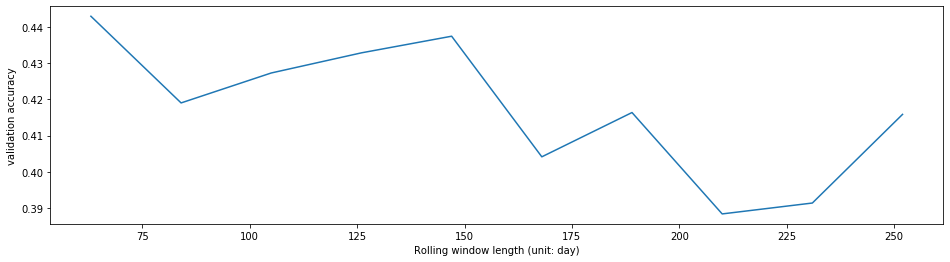

In [39]:
wl = [int(x) for x in vp_window.keys()]
v_accuracy = [x[100] for x in vp_window.values()]

plt.figure(figsize=(16,4))
plt.plot(wl, v_accuracy)
plt.ylabel('validation accuracy')
plt.xlabel('Rolling window length (unit: day)')

From the graph we can see that the maximum accuracy is achieved when the window length is 63 trading days.

In [40]:
op_wl = 63

## Applicate our model on test set

In [27]:
y_real, y_pred = Rolling_model(df1, valid = False, test = True, test_para = 100, n_splits = 5, th = 0.035, m = 3, n = 63, k = 1, parameters=None)

0 of 528
1 of 528
2 of 528
3 of 528
4 of 528
5 of 528
6 of 528
7 of 528
8 of 528
9 of 528
10 of 528
11 of 528
12 of 528
13 of 528
14 of 528
15 of 528
16 of 528
17 of 528
18 of 528
19 of 528
20 of 528
21 of 528
22 of 528
23 of 528
24 of 528
25 of 528
26 of 528
27 of 528
28 of 528
29 of 528
30 of 528
31 of 528
32 of 528
33 of 528
34 of 528
35 of 528
36 of 528
37 of 528
38 of 528
39 of 528
40 of 528
41 of 528
42 of 528
43 of 528
44 of 528
45 of 528
46 of 528
47 of 528
48 of 528
49 of 528
50 of 528
51 of 528
52 of 528
53 of 528
54 of 528
55 of 528
56 of 528
57 of 528
58 of 528
59 of 528
60 of 528
61 of 528
62 of 528
63 of 528
64 of 528
65 of 528
66 of 528
67 of 528
68 of 528
69 of 528
70 of 528
71 of 528
72 of 528
73 of 528
74 of 528
75 of 528
76 of 528
77 of 528
78 of 528
79 of 528
80 of 528
81 of 528
82 of 528
83 of 528
84 of 528
85 of 528
86 of 528
87 of 528
88 of 528
89 of 528
90 of 528
91 of 528
92 of 528
93 of 528
94 of 528
95 of 528
96 of 528
97 of 528
98 of 528
99 of 528
100 of 528

In [28]:
len(y_real)

104229

In [29]:
len(y_pred)

104229

In [30]:
sum(y_pred == y_real)

49468

In [31]:
Accuracy = sum(y_pred == y_real)/len(y_real)
Accuracy

0.474608794097612

## Backtesting on Companies

### 1. Backtesting on the company AAN

In [229]:
d = r'indicator_AAN UN Equity.csv'
data = pd.read_csv(d)
del data['Unnamed: 0']
data['Dates'] = pd.to_datetime(data['Dates'])
for x in [ 'return5', 'return10', 'signal5', 'signal10']:
    del data[x]
# data = data.iloc[:,0:6]
data['SMA50'] = data['PX_LAST'].rolling(50).mean()
data['SMA200'] = data['PX_LAST'].rolling(200).mean()

data = data[data['Dates'] >= df1.iloc[0,0]]
data = data[data['Dates'] <= df1.iloc[-1,0]]
data

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,SAR_crossover,TEMA_crossover,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3
2015,2007-10-09,180750,14.9867,14.7867,15.0600,14.8667,1.0,16.167600,18.087737,0.0,...,0,0,0,0.0,-1.0,0.0,1.0,0.0,0.008526,0
2016,2007-10-10,241650,14.6933,14.6733,14.9667,14.9667,-1.0,16.154132,18.067203,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.025643,0
2017,2007-10-11,413850,14.1733,14.1000,14.7400,14.7400,0.0,16.126132,18.042036,0.0,...,0,0,0,0.0,0.0,0.0,-1.0,-1.0,-0.044494,-1
2018,2007-10-12,221100,14.2867,14.0533,14.5400,14.1533,0.0,16.104400,18.019570,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-0.046708,-1
2019,2007-10-15,257850,14.0733,14.0067,14.2867,14.2467,0.0,16.070266,17.994603,0.0,...,0,0,0,0.0,1.0,0.0,0.0,0.0,-0.042196,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,2010-01-07,214050,18.7400,18.5733,19.0667,18.8133,0.0,18.124802,18.978101,0.0,...,0,0,0,0.0,-1.0,0.0,0.0,0.0,0.010787,0
2603,2010-01-08,155700,18.7600,18.6067,18.8867,18.7800,0.0,18.166002,18.978767,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.008602,0
2604,2010-01-11,188400,19.0933,18.6333,19.0933,18.8533,1.0,18.202802,18.982167,1.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.018853,0
2605,2010-01-12,144150,18.9867,18.8400,19.1667,19.0667,0.0,18.231870,18.984534,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.013164,0


In [76]:
m=3
th = 0.035
k = 1
n = 63
test_para = 100

df = df1.copy()
df.sort_values("Dates",inplace=True)

X = df['Dates'].unique()
N = len(X) 
df['return'+str(m)] = df['intraday_return'].shift(-m)
df = df.dropna()
df['signal'+str(m)] = np.where(df['return'+str(m)] > th, 1 ,np.where(df['return'+str(m)] < -th, -1, 0))   
y_real = np.array([],dtype='int')
y_pred = np.array([],dtype='int')

step = 0
for i in range(0,N-(n+k),k):
    print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
    step = step + 1

    y_real = np.concatenate((y_real,np.array(df[df['Dates'] == X[i+n+m]]['signal'+str(m)])))

    train_dates = pd.to_datetime(X[i:i+n])
    f = lambda x: True if x in train_dates else False
    train = df[df['Dates'].apply(f)]
    x_train = train.iloc[:,6:-3]
    y_train = train.iloc[:,-2:]

    x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = test_para)

    model = RandomForestClassifier(n_estimators = test_para)
    model.fit(x_train,y_train['signal'+str(m)])
    
    

    test_data = data[data['Dates'] == X[i+n+m]]
    x_test = test_data.iloc[:,6:-2]
    y_test = test_data.iloc[:,-2:]

    x_test = feature_combination(x_test, list(x_train.columns))

    prediction = model.predict(x_test)
    y_pred = np.concatenate((y_pred, np.array(prediction)))

0 of 528
1 of 528
2 of 528
3 of 528
4 of 528
5 of 528
6 of 528
7 of 528
8 of 528
9 of 528
10 of 528
11 of 528
12 of 528
13 of 528
14 of 528
15 of 528
16 of 528
17 of 528
18 of 528
19 of 528
20 of 528
21 of 528
22 of 528
23 of 528
24 of 528
25 of 528
26 of 528
27 of 528
28 of 528
29 of 528
30 of 528
31 of 528
32 of 528
33 of 528
34 of 528
35 of 528
36 of 528
37 of 528
38 of 528
39 of 528
40 of 528
41 of 528
42 of 528
43 of 528
44 of 528
45 of 528
46 of 528
47 of 528
48 of 528
49 of 528
50 of 528
51 of 528
52 of 528
53 of 528
54 of 528
55 of 528
56 of 528
57 of 528
58 of 528
59 of 528
60 of 528
61 of 528
62 of 528
63 of 528
64 of 528
65 of 528
66 of 528
67 of 528
68 of 528
69 of 528
70 of 528
71 of 528
72 of 528
73 of 528
74 of 528
75 of 528
76 of 528
77 of 528
78 of 528
79 of 528
80 of 528
81 of 528
82 of 528
83 of 528
84 of 528
85 of 528
86 of 528
87 of 528
88 of 528
89 of 528
90 of 528
91 of 528
92 of 528
93 of 528
94 of 528
95 of 528
96 of 528
97 of 528
98 of 528
99 of 528
100 of 528

IndexError: index 592 is out of bounds for axis 0 with size 592

In [231]:
data_test = data.iloc[-526:,:]
data_test['pred'] = y_pred
data_test

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,TEMA_crossover,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3,pred
2081,2008-01-09,264450,11.7000,11.2400,11.7200,11.4733,0.0,12.992004,16.257702,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,-0.004535,0,0
2082,2008-01-10,274500,11.5333,11.2933,11.6933,11.5267,0.0,12.949070,16.228602,0.0,...,0,0,0.0,1.0,0.0,0.0,0.0,-0.042617,-1,0
2083,2008-01-11,286950,11.0333,10.9400,11.5133,11.5000,0.0,12.899070,16.197002,0.0,...,0,0,0.0,-1.0,0.0,0.0,0.0,-0.044463,-1,0
2084,2008-01-14,287850,11.3667,11.1000,11.4400,11.1733,0.0,12.854804,16.167002,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,-0.028487,0,0
2085,2008-01-15,177000,11.0467,10.9200,11.2333,11.1800,0.0,12.804004,16.133469,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,-0.042191,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,2010-01-07,214050,18.7400,18.5733,19.0667,18.8133,0.0,18.124802,18.978101,0.0,...,0,0,0.0,-1.0,0.0,0.0,0.0,0.010787,0,0
2603,2010-01-08,155700,18.7600,18.6067,18.8867,18.7800,0.0,18.166002,18.978767,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.008602,0,0
2604,2010-01-11,188400,19.0933,18.6333,19.0933,18.8533,1.0,18.202802,18.982167,1.0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.018853,0,0
2605,2010-01-12,144150,18.9867,18.8400,19.1667,19.0667,0.0,18.231870,18.984534,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.013164,0,0


In [233]:
data_test['Stance']=np.zeros(data_test.shape[0])
data_test

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3,pred,Stance
2081,2008-01-09,264450,11.7000,11.2400,11.7200,11.4733,0.0,12.992004,16.257702,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.004535,0,0,0.0
2082,2008-01-10,274500,11.5333,11.2933,11.6933,11.5267,0.0,12.949070,16.228602,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.042617,-1,0,0.0
2083,2008-01-11,286950,11.0333,10.9400,11.5133,11.5000,0.0,12.899070,16.197002,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.044463,-1,0,0.0
2084,2008-01-14,287850,11.3667,11.1000,11.4400,11.1733,0.0,12.854804,16.167002,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.028487,0,0,0.0
2085,2008-01-15,177000,11.0467,10.9200,11.2333,11.1800,0.0,12.804004,16.133469,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.042191,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,2010-01-07,214050,18.7400,18.5733,19.0667,18.8133,0.0,18.124802,18.978101,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,0.010787,0,0,0.0
2603,2010-01-08,155700,18.7600,18.6067,18.8867,18.7800,0.0,18.166002,18.978767,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.008602,0,0,0.0
2604,2010-01-11,188400,19.0933,18.6333,19.0933,18.8533,1.0,18.202802,18.982167,1.0,...,0,0.0,0.0,0.0,0.0,1.0,0.018853,0,0,0.0
2605,2010-01-12,144150,18.9867,18.8400,19.1667,19.0667,0.0,18.231870,18.984534,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.013164,0,0,0.0


In [234]:
for i in range(1, data_test.shape[0]):
    if data_test.iloc[i,-2] == 1 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == 0 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 0
        
    if data_test.iloc[i,-2] == -1 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 0
        
    if data_test.iloc[i,-2] == 1 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == 0 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == -1 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 0

data_test.head(50)

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3,pred,Stance
2081,2008-01-09,264450,11.7000,11.2400,11.7200,11.4733,0.0,12.992004,16.257702,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.004535,0,0,0.0
2082,2008-01-10,274500,11.5333,11.2933,11.6933,11.5267,0.0,12.949070,16.228602,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.042617,-1,0,0.0
2083,2008-01-11,286950,11.0333,10.9400,11.5133,11.5000,0.0,12.899070,16.197002,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.044463,-1,0,0.0
2084,2008-01-14,287850,11.3667,11.1000,11.4400,11.1733,0.0,12.854804,16.167002,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.028487,0,0,0.0
2085,2008-01-15,177000,11.0467,10.9200,11.2333,11.1800,0.0,12.804004,16.133469,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.042191,-1,0,0.0
2086,2008-01-16,372300,11.3667,10.9667,11.5200,11.0400,0.0,12.763738,16.102369,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.030218,1,0,0.0
2087,2008-01-17,320850,10.7467,10.7000,11.4333,11.3600,0.0,12.714406,16.068903,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.054545,-1,0,0.0
2088,2008-01-18,689100,10.2000,10.2000,10.9467,10.7200,0.0,12.663206,16.031736,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.076647,-1,0,0.0
2089,2008-01-21,689100,10.2000,10.2000,10.9467,10.7200,0.0,12.596940,15.993436,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.102642,-1,0,0.0
2090,2008-01-22,1511550,11.3267,8.9333,12.0467,8.9600,0.0,12.541608,15.960536,0.0,...,0,0.0,0.0,0.0,0.0,1.0,0.053970,1,0,0.0


### Show the Stance of our trading strategy

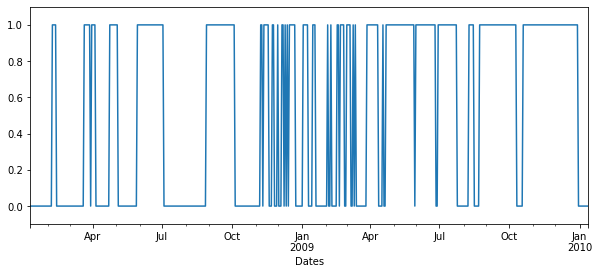

In [235]:
data_test.set_index(data_test['Dates'], inplace = True)
data_test['Stance'].plot(ylim=[-0.1,1.1], figsize=(10,4))

### Plot the stock price and its 50-day and 200-day moving average

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


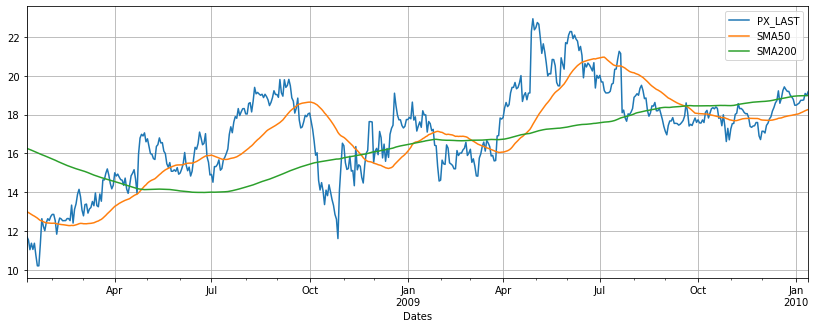

In [238]:
data_test[['PX_LAST','SMA50','SMA200']].plot(grid=True, figsize=(14,5))
data_test['Stance_2'] = np.where(data_test['SMA50'] - data_test['SMA200'] > 0, 1, 0)

### Comparison betweent or strategy and double moving average strategy

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

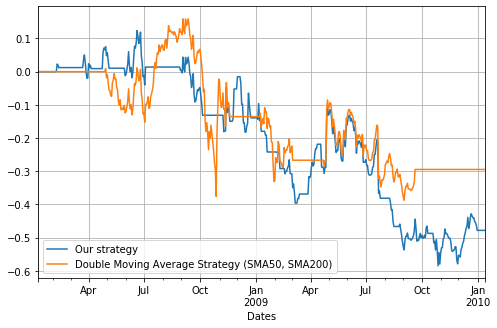

In [241]:
data_test['return'] = np.log(data_test['PX_LAST'] / data_test['PX_LAST'].shift(1))
data_test['Our strategy'] = data_test['return'] * data_test['Stance'].shift(1)
data_test['Double Moving Average Strategy (SMA50, SMA200)'] = data_test['return'] * data_test['Stance_2'].shift(1)
data_test[['Our strategy','Double Moving Average Strategy (SMA50, SMA200)']].cumsum().plot(grid=True,figsize=(8,5))

The graph does not show the our strategy is better than other strategy. We think the reason is that our model is trained based on all the companies in the consumer disrectionaty sector of Russell 3000 index, which shows a clear drawdown+recovery pattern in recessions. However this stock does not show this pattern here, so we decide to test our model on another stock

### 2. Backtesting on the company AAP

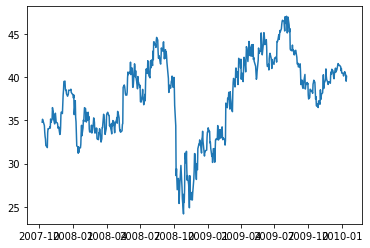

In [242]:
d = r'indicator_AAP UN Equity.csv'
data = pd.read_csv(d)
del data['Unnamed: 0']
data['Dates'] = pd.to_datetime(data['Dates'])
for x in [ 'return5', 'return10', 'signal5', 'signal10']:
    del data[x]
# data = data.iloc[:,0:6]
data['SMA50'] = data['PX_LAST'].rolling(50).mean()
data['SMA200'] = data['PX_LAST'].rolling(200).mean()

data = data[data['Dates'] >= df1.iloc[0,0]]
data = data[data['Dates'] <= df1.iloc[-1,0]]
plt.plot(data['Dates'],data['PX_LAST'])

In [211]:
m=3
th = 0.035
k = 1
n = 63
test_para = 100
step = 0

df = df1.copy()
df.sort_values("Dates",inplace=True)

X = df['Dates'].unique()
N = len(X) 
df['return'+str(m)] = df['intraday_return'].shift(-m)
df = df.dropna()
df['signal'+str(m)] = np.where(df['return'+str(m)] > th, 1 ,np.where(df['return'+str(m)] < -th, -1, 0))   

y_real2 = np.array([],dtype='int')
y_pred2 = np.array([],dtype='int')

for i in range(0,N-(n+k),k):
    print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
    step = step + 1

    y_real2 = np.concatenate((y_real2,np.array(df[df['Dates'] == X[i+n+m]]['signal'+str(m)])))

    train_dates = pd.to_datetime(X[i:i+n])
    f = lambda x: True if x in train_dates else False
    train = df[df['Dates'].apply(f)]
    x_train = train.iloc[:,6:-3]
    y_train = train.iloc[:,-2:]

    x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = test_para)

    model = RandomForestClassifier(n_estimators = test_para)
    model.fit(x_train,y_train['signal'+str(m)])
    
    

    test_data = data[data['Dates'] == X[i+n+m]]
    x_test = test_data.iloc[:,6:-2]
    y_test = test_data.iloc[:,-2:]

    x_test = feature_combination(x_test, list(x_train.columns))

    prediction = model.predict(x_test)
    y_pred2 = np.concatenate((y_pred2, np.array(prediction)))

0 of 528
1 of 528
2 of 528
3 of 528
4 of 528
5 of 528
6 of 528
7 of 528
8 of 528
9 of 528
10 of 528
11 of 528
12 of 528
13 of 528
14 of 528
15 of 528
16 of 528
17 of 528
18 of 528
19 of 528
20 of 528
21 of 528
22 of 528
23 of 528
24 of 528
25 of 528
26 of 528
27 of 528
28 of 528
29 of 528
30 of 528
31 of 528
32 of 528
33 of 528
34 of 528
35 of 528
36 of 528
37 of 528
38 of 528
39 of 528
40 of 528
41 of 528
42 of 528
43 of 528
44 of 528
45 of 528
46 of 528
47 of 528
48 of 528
49 of 528
50 of 528
51 of 528
52 of 528
53 of 528
54 of 528
55 of 528
56 of 528
57 of 528
58 of 528
59 of 528
60 of 528
61 of 528
62 of 528
63 of 528
64 of 528
65 of 528
66 of 528
67 of 528
68 of 528
69 of 528
70 of 528
71 of 528
72 of 528
73 of 528
74 of 528
75 of 528
76 of 528
77 of 528
78 of 528
79 of 528
80 of 528
81 of 528
82 of 528
83 of 528
84 of 528
85 of 528
86 of 528
87 of 528
88 of 528
89 of 528
90 of 528
91 of 528
92 of 528
93 of 528
94 of 528
95 of 528
96 of 528
97 of 528
98 of 528
99 of 528
100 of 528

IndexError: index 592 is out of bounds for axis 0 with size 592

In [243]:
data_test = data.iloc[-526:,:]
data_test['pred'] = y_pred2
data_test['pred'].unique()

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([ 0, -1,  1], dtype=int64)

In [244]:
data_test['Stance']=np.zeros(data_test.shape[0])
data_test

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3,pred,Stance
1584,2008-01-09,1006800.0,34.83,33.46,35.97,35.48,0.0,36.5768,37.25155,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.023549,0,0,0.0
1585,2008-01-10,1452900.0,33.62,32.64,34.32,34.07,0.0,36.5460,37.22185,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.098176,-1,0,0.0
1586,2008-01-11,1014500.0,32.05,32.00,33.10,33.06,0.0,36.4914,37.18430,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.093096,-1,0,0.0
1587,2008-01-14,1309700.0,31.91,30.17,32.12,30.95,0.0,36.4266,37.14645,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.083836,-1,0,0.0
1588,2008-01-15,482600.0,31.20,30.99,31.96,31.41,0.0,36.3210,37.10350,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.071981,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,2010-01-07,524900.0,40.48,39.71,40.54,39.71,0.0,39.9618,41.52295,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.002476,0,0,0.0
2106,2010-01-08,394200.0,40.64,40.11,40.82,40.25,0.0,40.0294,41.52360,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.012456,0,0,0.0
2107,2010-01-11,367700.0,40.24,40.09,40.76,40.72,0.0,40.0968,41.52330,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.006174,0,0,0.0
2108,2010-01-12,602900.0,39.54,38.84,39.72,39.28,0.0,40.1168,41.52355,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.023221,0,0,0.0


In [245]:
for i in range(1, data_test.shape[0]):
    if data_test.iloc[i,-2] == 1 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == 0 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 0
        
    if data_test.iloc[i,-2] == -1 and data_test.iloc[i-1,-1] == 0:
        data_test.iloc[i,-1] = 0
        
    if data_test.iloc[i,-2] == 1 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == 0 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 1
        
    if data_test.iloc[i,-2] == -1 and data_test.iloc[i-1,-1] == 1:
        data_test.iloc[i,-1] = 0

data_test.head(50)

,Dates,PX_VOLUME,PX_LAST,PX_LOW,PX_HIGH,PX_OPEN,SMA14,SMA50,SMA200,SMA5-10,...,OBV_divergence,ATR_close,HT_crossover,CMO_crossover,MACD_crossover_12_29_9,MACD_crossover_5_35_5,return3,signal3,pred,Stance
1584,2008-01-09,1006800.0,34.83,33.46,35.97,35.48,0.0,36.5768,37.25155,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.023549,0,0,0.0
1585,2008-01-10,1452900.0,33.62,32.64,34.32,34.07,0.0,36.5460,37.22185,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.098176,-1,0,0.0
1586,2008-01-11,1014500.0,32.05,32.00,33.10,33.06,0.0,36.4914,37.18430,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.093096,-1,0,0.0
1587,2008-01-14,1309700.0,31.91,30.17,32.12,30.95,0.0,36.4266,37.14645,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.083836,-1,0,0.0
1588,2008-01-15,482600.0,31.20,30.99,31.96,31.41,0.0,36.3210,37.10350,0.0,...,0,0.0,1.0,0.0,0.0,0.0,-0.071981,-1,0,0.0
1589,2008-01-16,614700.0,31.93,31.21,32.41,31.36,0.0,36.2358,37.06240,0.0,...,0,0.0,-1.0,0.0,0.0,0.0,-0.003744,0,0,0.0
1590,2008-01-17,553500.0,31.31,31.28,32.49,31.84,0.0,36.1410,37.01920,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.018803,0,0,0.0
1591,2008-01-18,599600.0,31.82,31.19,32.20,31.47,0.0,36.0742,36.98005,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.019872,0,0,0.0
1592,2008-01-21,599600.0,31.82,31.19,32.20,31.47,0.0,36.0188,36.93790,0.0,...,0,0.0,0.0,0.0,0.0,0.0,-0.003445,0,0,0.0
1593,2008-01-22,564900.0,32.23,30.55,32.64,30.55,0.0,35.9496,36.89805,0.0,...,0,0.0,0.0,0.0,0.0,1.0,0.029384,0,0,0.0


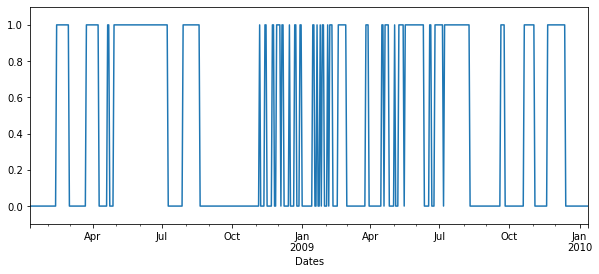

In [246]:
data_test.set_index(data_test['Dates'], inplace = True)
data_test['Stance'].plot(ylim=[-0.1,1.1], figsize=(10,4))

### Plot the stock price and its 50-day and 200-day moving average
From the graph we can see that the this stock shows a clear recesson pattern

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


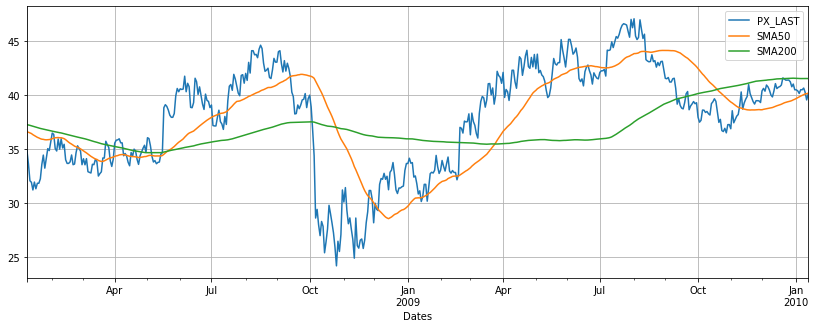

In [247]:
data_test[['PX_LAST','SMA50','SMA200']].plot(grid=True, figsize=(14,5))
data_test['Stance_2'] = np.where(data_test['SMA50'] - data_test['SMA200'] > 0, 1, 0)

### Comparison betweent or strategy and double moving average strategy

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

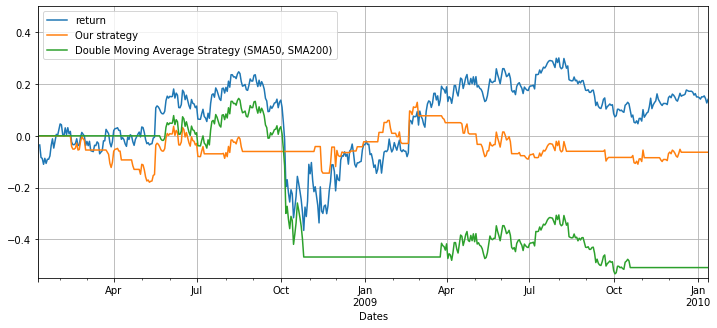

In [250]:
data_test['return'] = np.log(data_test['PX_LAST'] / data_test['PX_LAST'].shift(1))
data_test['Our strategy'] = data_test['return'] * data_test['Stance'].shift(1)
data_test['Double Moving Average Strategy (SMA50, SMA200)'] = data_test['return'] * data_test['Stance_2'].shift(1)
data_test[['return','Our strategy','Double Moving Average Strategy (SMA50, SMA200)']].cumsum().plot(grid=True,figsize=(12,5),ylim=[-0.55,0.5])

- From the graph above we can see that our strategy outperform the double moving average strategy.
- Also, our strategy efficiently avoid the negative effect of the big drawdown in the 2008 recession